In [13]:
# General
import numpy
import os

# Processing
import pandas as pd

# Drawing
import cartopy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io import shapereader

# Processing Data

In [14]:
raw_data = pd.read_excel(os.path.join(os.getcwd(), 'datasets', 'coronavirus-enforcement-information-to-9-june-2021.xlsx'), sheet_name=1)
raw_data.drop(['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17'], axis=1, inplace=True)
raw_data.head()

,Date,Division Letter,SD Letter,Area Commands,Asked / Informed,Warned / Instructed,Removed from Place or Premises,FPN,Arrested
0,2020-03-27,A,AE,Moray,3,1,0,0,0
1,2020-03-27,G,GA,Glasgow South West,17,0,0,0,0
2,2020-03-27,J,JB,Scottish Borders,2,2,0,0,0
3,2020-03-27,L,LA,West Dumbartonshire,12,0,1,1,0
4,2020-03-27,N,NaN,Inverness,1,0,0,0,0


In [34]:
# Taking account of NaNs
# Explanation:
# The xlsx to pandas dataframe conversion seems to have taken "NA" for a division "N" and an Area Command "Inverness"
# and interpret that "NA" as actually: "NaN". Which is very annoying. So the below overwrites the SD letter of area commands
# that are inverness and turns them back to "NA"
raw_data.loc[raw_data["Area Commands"] == "Inverness", "SD Letter"] = raw_data["SD Letter"].fillna("NA")

In [35]:
raw_data.isnull().sum().sum()

0

In [36]:
raw_data.head()

,Date,Division Letter,SD Letter,Area Commands,Asked / Informed,Warned / Instructed,Removed from Place or Premises,FPN,Arrested
0,2020-03-27,A,AE,Moray,3,1,0,0,0
1,2020-03-27,G,GA,Glasgow South West,17,0,0,0,0
2,2020-03-27,J,JB,Scottish Borders,2,2,0,0,0
3,2020-03-27,L,LA,West Dumbartonshire,12,0,1,1,0
4,2020-03-27,N,NA,Inverness,1,0,0,0,0


In [22]:
df1 = raw_data[raw_data.isna().any(axis=1)]
df1['SD Letter'] = df1['SD Letter'].fillna("NA")
df1.isna().sum().sum()
#print (df1)

<ipython-input-22-72f7cafc7694>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['SD Letter'] = df1['SD Letter'].fillna("NA")


0

## Group by Division - across all time

# Drawing Data

[]

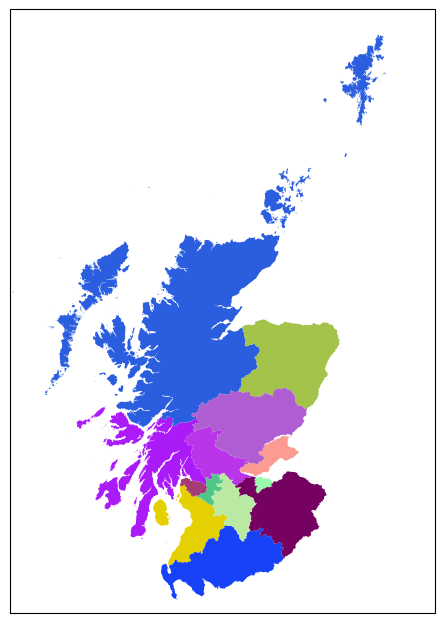

In [ ]:
# Creating new figure and axes instances
fig = plt.figure(figsize=(6,8), dpi=100)
projectionPARAM = ccrs.TransverseMercator(central_longitude=-2.0, central_latitude=49.0, false_easting=400000.0, false_northing=-100000.0, scale_factor=0.9996012717, approx=False)
ax = fig.add_subplot(1, 1, 1, projection=projectionPARAM)
ax.set_extent([-8, 0, 54.5, 61]) # Ideal coordinate map range for plotting Scotland

# Downloaded from: https://spatialdata.gov.scot/geonetwork/srv/eng/catalog.search;jsessionid=61F713CF39B3EE2F440F48E9C31BA806#/metadata/4364af71-167a-4236-b5a0-bd4109913231
area_file = os.path.join(os.getcwd(), 'datasets', 'ScottishPoliceDivisions', 'SG_ScottishPoliceDivisions_2019.shp')
police_divisions = shapereader.Reader(area_file)

for record in police_divisions.records():
    name = record.attributes['PDivName']
    ax.add_geometries(
            [record.geometry],
            facecolor=numpy.random.rand(3,),
            linewidth=0,
            crs=projectionPARAM,
    )

plt.plot()

###
# Copyright Scottish Government, contains Ordnance Survey data © Crown copyright and database right (2021)
###